<a href="https://colab.research.google.com/github/polrgn/UPC-Final-Project-Bayesian-Analysis/blob/master/Excess_mortality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages(c("rstan","ggplot2","tidyr",
"kableExtra","tidyverse","gridExtra","bayesplot"))


library(rstan)
library(ggplot2)
library(tidyr)
library(kableExtra)
library(tidyverse)
library(gridExtra)
library(bayesplot)


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘matrixStats’, ‘StanHeaders’, ‘inline’, ‘loo’, ‘RcppEigen’, ‘webshot’, ‘ggridges’


Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘tidyr’


The following object is masked from ‘package:rstan’:

    extract


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()    masks rstan::extract()
✖ dplyr::filter()     m

Parameters

In [0]:
  stanfile <- "Neg_bin_time_dep.stan"
  iter <- 5000
  adapt_delta <-0.99
  max_treedepth <-15

# Problem

As of May 15th 2020, the global death toll of the unfolding COVID-19 outbreak stands at 302 493 (*citation needed*). The global and national official death toll figures have drawn much attention and sparked vivid debate because they are at the center of the evaluation and comparison of the public health responses of national and local governments. 

Among the controversies, there is first a debate on the severity of COVID-19 when compared to the yearly flu outbreak. Brazil's President Jair Bolsonaro refered the COVID-19 as a 'little flu' and refused to implement in his country the drastic lockdown measures that many other countries have enforced (*citation needed*). 

Second, the limits of testing in terms of tests availability and accuracy have led many observers to point at a likely underreporting of deaths due to the novel virus. Moreover, deaths that might be indirectly due to the COVID-19 crisis because of, for example, a collapse of the health system, are not counted in official figures. On April 26th 2020, the Financial Times headlined that global coronavirus death toll could be 60% higher than reported (*citation needed*). 

Finally, differences in testing and reporting policies across countries but also regions have casted more doubts on the veracity of the reporting figures. Belgium has reported the highest number of deaths per 100 000 inhabitants but Belgian officials also say they are counting in a way that no other country in the world is currently doing: counting deaths in hospitals and care homes, but also including deaths in care homes that are suspected, not confirmed, as COVID-19 cases (*citation needed*).

There is a need of a rigorous estimation of the excess mortality in the weeks of the outbreak. A direct week by week comparison of the observed number of deaths to historical averages as done by the Financial Times analysts is a first approach but is deeply limited as it fails to consider the variance of the number of deaths across years. 

In this report, we propose a Bayesian approach to estimate the excess mortality in the outbreak weeks through relative risk. Our model intends to provide parts of the answer to the following questions:

* Is mortality significantly higher than usual in weeks of the outbreak?

* If confirmed, is there significant excess mortality on top of the reported COVID deaths?

<!-- * Can country to country differences in known risk factors explain the differences in mortality?  -->

# Data

## Description

Every European state has an established monitoring system of death of nationals, often centralized by the local national statistics institute. Those platforms offer a good quality and reliable source to estimate excess mortality. We gathered weekly data of the total number of deaths for weeks 2 to 17 in the following countries and following years:

* Norway: years 2014 to 2020 

* Netherland: years 2017 to 2020

* Belgium: years 2009 to 2020

* Germany: years 2016 to 2020

* Switzerland: years 2015 to 2020

* Italy: years 2015 to 2020

* France: years 2010 to 2020

* England and Wales: years 2010 to 2020

The data have been retrieved from national statistic institutes of the respective countries. For each country the data were transformed to a similar structure than can be visualized below. 

```{r, eval = TRUE}
df <- head(read.csv("data/Death_week_2_17_netherland.csv", sep = ";"))
kable(df,
  align = "c",
  caption = "Number of deaths by week in the Netherlands")
```

## Exploratory data analysis

### Visualization

Fig.\ref{fig:fig1} and Fig.\ref{fig:fig2} show the weekly deaths over weeks 1 to 17 for each of the countries and over the years. Most countries show the same pattern with a large peak between weeks 10 and 16 in 2020 which clearly stands out of from other years. Notably, Switzerland show a peak in the same weeks in 2020 but it is not larger than other peaks observed in previous years. Norway shows no peak, and on a contrary it shows a trough, which might be the number of deaths for an incomplete week.

```{r, , eval = TRUE}
data_netherland<- read.csv("data/Death_week_2_17_netherland.csv", sep = ";")
data_england_wales <- read.csv("data/England_Wales_weekly.csv",sep = ";")
data_italy <- read.csv("data/italy_week_deaths.csv", sep = ",")
data_norway<- read.csv("data/Norway_total_death.csv", sep = ";")
data_france<- read.csv("data/weekly_deaths_france_week1_16_years2010_2020.csv", sep = ",")
data_belgium<- read.csv("data/weekly_deaths_belgium_week1_17_years2009_2020.csv", sep = ",")
data_germany<- read.csv("data/germany.csv", sep = ";")
data_switzerland<- read.csv("data/switzerland.csv", sep = ";")

colnames(data_england_wales)[1] <- "week"
data_england_wales <- data_england_wales[,c(1:11,13)]
colnames(data_germany)[1] <- "week"
data_italy <- data_italy[,2:8]
data_netherland <- data_netherland[,1:5]
colnames(data_switzerland)[1] <- "week"
data_norway <- data_norway[,1:(ncol(data_norway)-1)]
data_norway$week <- 1:17

# data_netherland <- pivot_longer(data_netherland,cols = starts_with("X"),names_to = "year", values_to = "deaths")
# data_england_wales <- pivot_longer(data_england_wales,cols = starts_with("X"),names_to = "year", values_to = "deaths")
# data_italy <- pivot_longer(data_italy,cols = starts_with("X"),names_to = "year", values_to = "deaths")
# data_norway <- pivot_longer(data_norway,cols = starts_with("X"),names_to = "year", values_to = "deaths")
# data_france <- pivot_longer(data_france,cols = starts_with("X"),names_to = "year", values_to = "deaths")
# data_belgium <- pivot_longer(data_belgium,cols = starts_with("X"),names_to = "year", values_to = "deaths")
# data_germany <- pivot_longer(data_germany,cols = starts_with("X"),names_to = "year", values_to = "deaths")
# data_switzerland <- pivot_longer(data_switzerland,cols = starts_with("X"),names_to = "year", values_to = "deaths")

pivot_and_plot <- function(data){
  data <- pivot_longer(data,cols = starts_with("X"),names_to = "year", values_to = "deaths")
  p <- ggplot(data) + geom_line(aes(x=week,y=deaths,col=year)) +
    theme(legend.text=element_text(size=4))
  return(p)
}

datasets <- list(data_netherland,data_england_wales,
                 data_italy,data_norway,data_france,
                 data_belgium,data_germany,data_switzerland)
countries <- c("Netherlands","England & Wales","Italy","Norway",
               "France","Belgium","Germany","Switzerland")
plots <- list()

for(i in 1:length(datasets)){
  plots[[i]] <- pivot_and_plot(datasets[[i]]) + ggtitle(countries[i])
}
```

```{r, eval = TRUE, fig.cap="\\label{fig:fig1} Weekly deaths by year and country"}
grid.arrange(plots[[1]],plots[[2]],plots[[3]],plots[[4]],ncol=2)
```

```{r, eval = TRUE, fig.cap="\\label{fig:fig1bis} Weekly deaths by year and country bis"}
grid.arrange(plots[[5]],plots[[6]],plots[[7]],plots[[8]],ncol=2)
```

### Overdispersion

Our data is characterized by much larger variance than mean, it is overdispersed. For example, Table \ref{tab:tab1} shows the weekly means and variance for Belgium.

```{r, eval = TRUE}
trans_belgium <- t(data_belgium)[,7:16]
weekly_means <- colMeans(trans_belgium) 
weekly_var <- diag(cov(trans_belgium))

df <- rbind( weekly_means,weekly_var)
row.names(df) <- c("Mean","Variance")

kable(df, "latex",
  booktabs = T,
  align = "c",
  digits = 0,
  col.names = as.character(8:17),
  caption = "\\label{tab:tab1} Means and variances of weekly deaths in Belgium"
  ) %>%
  kable_styling(
    latex_options = c("hold_position", "condensed")
  )
```



# Model 

## Excess mortality

### Statistical model

We approach the modelling of excess mortality by estimating the relative risk $\theta$ understood as the ratio of weekly mortality during the COVID-19 outbreak and the weekly mortality in non-outbreak times.

$$Relative Risk_i = \theta_i = \frac{mortality_{COV,i}}{mortality_{noCOV,i}}=\frac{\frac{O_{COV,i}}{N}}{\frac{O_{noCOV,i}}{N}} = \frac{O_{COV,i}}{O_{noCOV,i}}$$

where $O_{COV,i}$ is the observed number of deaths in week $i$ of COVID outbreak, $O_{noCOV,i}$ the number of deaths for the same week in non-outbreak times and $N$ is the population assumed stable accross years.

The number of deaths $O$ is a count variable. For such variable, two commonly used statistical models are the Poisson model (1) and the negative binomial model (2) that we parametrize with location and scale parameters.

$$(1)\hspace{0.3cm}O_{COV,i} \sim \mathcal{P}(\lambda), \hspace{0.1cm}E(O_{COV,i}) = Var(O_{COV,i}) = \lambda$$

$$(2)\hspace{0.3cm}O_{COV,i} \sim \mathcal{NB}(\mu,\phi),\hspace{0.1cm} E(O_{COV,i}) = \mu, \hspace{0.1cm}V(O_{COV,i}) = \mu+ \frac{\mu^2}{\phi}$$

A major difference between the two is that the Poisson model assumes the mean is equal to the variance while the negative binomial model has one more parameter that allows for overdispersion.

We have:

$$O_{COV,i}= O_{noCOV,i}\theta_i \Rightarrow E(O_{COV,i})= E(O_{noCOV,i})\theta_i = E_i \theta_i$$

where $E_i$ is the expected number of deaths in week $i$ in non-outbreak times. For each week $i$, we estimate $E_i$  as the historical average of number of deaths in year prior to 2020.

We therefore define the following statistical models:

$$(1)\hspace{0.3cm}O_{COV,i} \sim \mathcal{P}( E_i \theta_i)$$

$$(2)\hspace{0.3cm}O_{COV,i} \sim \mathcal{NB}( E_i \theta_i,\phi)$$

In thoses models, a value of $\theta_i$ larger than 1 can be interpreted as excess mortality in week $i$ with respect to non-outbreak times and a value smaller than 1 as reduced mortality. This approach to modelling mortality is handy as the estimated value is standardized to the expected number of deaths and can therefore be compared between weeks and countries.

From the exploratory data analysis, we see that there is a clear time dependence in the weekly mortality. We then introduce a time structured random effect $\theta_t$ in our models. We use a autoregressive structure of order 1 as time strcuture. Our models are then as follows:

$$(1)\hspace{0.3cm}O_{COV,i} \sim \mathcal{P}( E_i\theta_i\theta_{t,i})$$

$$(2)\hspace{0.3cm}O_{COV,i} \sim \mathcal{NB}( E_i \theta_i\theta_{t,i},\phi)$$

where:
$$\log(\theta_{t,i}) = \alpha + \beta \log(\theta_{t,i-1}) $$

### Bayesian model

We propose hierarchichal models for our Bayesian estimation of $\theta$ and $\theta_t$. 

Poisson model (1):

$$(O_{COV,2},...,O_{COV,17}|(\theta_2,\theta_{t,2}),...,(\theta_{17},\theta_{t,17})) \sim \prod_{i=2}^{17}{\mathcal{P}(E_i \theta_i\theta_{t,i})}$$

with parameters priors:

$$(\log(\theta_2),...\log(\theta_{17})) \sim \mathcal{N}(0,\sigma)$$

$$\forall i,\log(\theta_{t,i}) = \alpha + \beta \log(\theta_{t,i-1}) +\epsilon, \hspace{0.15cm} \epsilon \sim \mathcal{N}(0,\sigma_t)$$


where $\sigma$, $\alpha$, $\beta$ and $\sigma_t$ are hyperparameters with hyperpriors:

$$\sigma \sim \mathcal{U}(a_{\sigma},b_{\sigma})$$
$$\alpha \sim \mathcal{N}(\mu_{\alpha},\sigma_{\alpha})$$
$$\beta \sim \mathcal{U}(a_{\beta},b_{\beta})$$
$$\sigma_t \sim \mathcal{N}(\mu_{\sigma_t},\sigma_{\sigma_t})$$

Similarly the negative binomial model (2) is:

Poisson model (1):

$$(O_{COV,2},...,O_{COV,17}|(\theta_2,\theta_{t,2}),..,(\theta_{17},\theta_{t,17})) \sim \prod_{i=2}^{17}{\mathcal{P}(E_i (\theta_i\theta_{t,i})}$$

with parameters priors:

$$(\log(\theta_2),...,\log(\theta_{17})) \sim \mathcal{N}(0,\sigma)$$

$$\forall i,\log(\theta_{t,i}) = \alpha + \beta \log(\theta_{t,i-1}) +\epsilon, \hspace{0.15cm} \epsilon \sim \mathcal{NB}( E_i \theta_i\theta_{t,i},\phi)$$

$$\phi \sim \mathcal{U}(a_{\phi},b_{\phi})$$

where $\sigma$, $\alpha$, $\beta$ and $\sigma_t$ are hyperparameters with hyperpriors:

$$\sigma \sim \mathcal{U}(a_{\sigma},b_{\sigma})$$
$$\alpha \sim \mathcal{N}(\mu_{\alpha},\sigma_{\alpha})$$
$$\beta \sim \mathcal{U}(a_{\beta},b_{\beta})$$
$$\sigma_t \sim \mathcal{N}(\mu_{\sigma_t},\sigma_{\sigma_t})$$

## Excess mortality on top of the reported COVID deaths

To model excess mortality on top of reported COVID deaths, we use the same approach as for modelling of excess mortality during the COVID-19 outbreak with respect to non-outbreak times. We previously estimated the relative risk $\theta$ understood as the ratio of weekly mortality during the COVID-19 outbreak and the weekly expected mortality in non-outbreak times. We now adjust the exptected mortality $E_i$ to account for COVID deaths.

$$Relative Risk_i = \theta_i = \frac{O_{COV,i}}{O_{noCOV,i}+D_i}$$

where $O_{COV,i}$ is the observed number of deaths in week $i$ of COVID outbreak, $O_{noCOV,i}$ the number of deaths for the same week in non-outbreak times and $D_i$ is the reported number of deaths due to COVID in week $i$.

We have:

$$\tilde{E_i}=E_i+D_i$$

# Results

## Poisson model

We started by estimating the above Poisson model in a simpler form, without the time dependence. The model resulted insuitable despite having tried numerous variations of the hierarchical model: changing the priors and levels of the multilevel model. Indeed, as can be observed in Fig. \ref{fig:fig2} for Belgium, the model adequately captured the change in relative risk in peak weeks but failed to adequately reflect variance with extremely narrow confidence intervals. We obtained similar results for the Netherlands, England & Wales, Italy and Germany. As a consequence, we abandonned the model.

```{r, eval = TRUE, fig.cap="\\label{fig:fig2} Poisson model estimates for Belgium",out.extra = "", fig.pos = 'h!', fig.align="center", out.height="50%"}
knitr::include_graphics("Poisson_belgium.png")
```

## Negative binomial model

The negative binomial model proved to be much more suited to our data. This is not surprising givent the overdispersion we observed in the exploratory data analysis.





Reading the data

In [0]:
data_netherland<- read.csv("data/Death_week_2_17_netherland.csv", sep = ";")
data_england_wales <- read.csv("data/England_Wales_weekly.csv",sep = ";")
data_italy <- read.csv("data/italy_week_deaths.csv", sep = ",")
data_norway<- read.csv("data/Norway_total_death.csv", sep = ";")
data_germany <-read.csv("data/germany.csv", sep = ";")
data_switzerland <- read.csv("data/switzerland.csv", sep = ";")
data_france <- read.csv("data/weekly_deaths_france_week1_16_years2010_2020.csv", header = T, sep = ",")
data_belgium <- read.csv("data/weekly_deaths_belgium_week1_17_years2009_2020.csv", header = T, sep = ",")

In [0]:
# Extracting the data for the Netherland
mean_netherland <- as.vector(as.matrix(data_netherland)[,6])
netherland_2020<-as.vector(as.matrix(data_netherland)[,5])

# Extracting data England and Wales

mean_england <- as.vector(as.matrix(data_england_wales)[,12])
england_2020 <- as.vector(as.matrix(data_england_wales)[,13])

# Extracting data Italy
data_italy <- data_italy[-14,]
mean_italy <- as.vector(as.matrix(data_italy)[,9])
italy_2020 <- as.vector(as.matrix(data_italy)[,8])

# Extracting the data for Norway

data_norway <- data_norway[-17, ]
mean_norway <- as.vector(as.matrix(data_norway)[,8])
norway_2020<-as.vector(as.matrix(data_norway)[,7])


# Extracting the data of Germany

mean_germany <- rowMeans(data_germany[, c(2,3,4,5)])
data_germany <- cbind(data_germany, mean_germany)
germany_2020 <- as.vector(as.matrix(data_germany)[,6])

# Extracting the data of Switzerland

mean_swiss <- rowMeans(data_switzerland[, c(3,4,5,6,7)])
data_switzerland <- cbind(data_switzerland, mean_swiss)
swiss_2020 <- as.vector(as.matrix(data_switzerland)[,2])

#Extracting the data of France

mean_france <- rowMeans(data_france[, c(2:11)])
data_france <- cbind(data_france, mean_france)
france_2020 <- as.vector(as.matrix(data_france)[,12])

#Extracting the data of Belgium
mean_belgium <- rowMeans(data_belgium[, c(2:12)])
data_belgium <- cbind(data_belgium, mean_belgium)
belgium_2020 <- as.vector(as.matrix(data_belgium)[,13])


### Setting up the stan lists

In [0]:
create_list <- function(N, E, O){
  data_list <-  list(
  N = N, 
  E = E,
  O = O,
  phi_a = 1,
  phi_b = 6000,
  sigma_a = 0.01,
  sigma_b = 4,
  alpha_mu = 0,
  alpha_sigma = 4,
  beta_a = -1, 
  beta_b = 1,
  sigma_time_mu = 0,
  sigma_time_sigma= 25
  )
  return(data_list)
}

In [0]:

data_list_netherland <- create_list(length(mean_netherland), mean_netherland, netherland_2020)
data_list_england_wales <- create_list( length(mean_england),mean_england,england_2020 )
data_list_italy <- create_list(length(mean_italy), mean_italy, italy_2020)
data_list_norway <- create_list(length(mean_norway), mean_norway, norway_2020)
data_list_france <- create_list(length(mean_france), mean_france, france_2020)
data_list_belgium <- create_list(length(mean_belgium), mean_belgium, belgium_2020)
data_list_germany <- create_list(length(mean_germany), mean_germany, germany_2020)
data_list_switzerland <- create_list(length(mean_swiss), mean_swiss, swiss_2020)


Fit the stan models

In [15]:

risk_netherland <- stan(stanfile, iter = iter, chains = 4,
  data = data_list_netherland, seed = 1, control = list(adapt_delta = adapt_delta, max_treedepth = max_treedepth))

risk_england_wales <- stan(stanfile, iter = iter, chains = 4,
  data = data_list_england_wales, seed = 1, control = list(adapt_delta = adapt_delta, max_treedepth = max_treedepth))

risk_italy <- stan(stanfile, iter = iter, chains = 4,
  data = data_list_italy, seed = 1, control = list(adapt_delta = adapt_delta, max_treedepth = max_treedepth))

risk_norway <- stan(stanfile, iter = iter, chains = 4,
  data = data_list_norway, seed = 1, control = list(adapt_delta = adapt_delta, max_treedepth = max_treedepth))

risk_germany <- stan(stanfile, iter = iter, chains = 4,
  data = data_list_germany, seed = 1, control = list(adapt_delta = adapt_delta, max_treedepth = max_treedepth))

risk_switzerland <- stan(stanfile, iter = iter, chains = 4,
  data = data_list_switzerland, seed = 1, control = list(adapt_delta = adapt_delta, max_treedepth = max_treedepth))

risk_france <- stan(stanfile, iter = iter, chains = 4,
  data = data_list_france, seed = 1, control = list(adapt_delta = adapt_delta, max_treedepth = max_treedepth))

risk_belgium <- stan(stanfile, iter = iter, chains = 4,
  data = data_list_belgium, seed = 1, control = list(adapt_delta = adapt_delta, max_treedepth = max_treedepth))


SAMPLING FOR MODEL 'Neg_bin_time_dep' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Warmup)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Warmup)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Warmup)
Chain 1: Iteration: 2501 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 7.4058 seconds (Warm-up)
Chain 1:                4.7338 seconds (Sampling)
Chain 1:            

Warning message:
“There were 7687 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”



SAMPLING FOR MODEL 'Neg_bin_time_dep' NOW (CHAIN 1).
Chain 1: Rejecting initial value:
Chain 1:   Log probability evaluates to log(0), i.e. negative infinity.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: Rejecting initial value:
Chain 1:   Log probability evaluates to log(0), i.e. negative infinity.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: 
Chain 1: Gradient evaluation took 2.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Warmup)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Warmup)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Warmup)
Chain 1: Iteration: 2501 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Samplin

Warning message:
“There were 7805 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”



SAMPLING FOR MODEL 'Neg_bin_time_dep' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Warmup)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Warmup)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Warmup)
Chain 1: Iteration: 2501 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 18.2806 seconds (Warm-up)
Chain 1:                3.53483 seconds (Sampling)
Chain 1:          

Warning message:
“There were 7718 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”



SAMPLING FOR MODEL 'Neg_bin_time_dep' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Warmup)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Warmup)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Warmup)
Chain 1: Iteration: 2501 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 9.24722 seconds (Warm-up)
Chain 1:                3.02774 seconds (Sampling)
Chain 1:             

Warning message:
“There were 8582 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”



SAMPLING FOR MODEL 'Neg_bin_time_dep' NOW (CHAIN 1).
Chain 1: Rejecting initial value:
Chain 1:   Log probability evaluates to log(0), i.e. negative infinity.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: Rejecting initial value:
Chain 1:   Log probability evaluates to log(0), i.e. negative infinity.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: Rejecting initial value:
Chain 1:   Log probability evaluates to log(0), i.e. negative infinity.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: Rejecting initial value:
Chain 1:   Log probability evaluates to log(0), i.e. negative infinity.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: Rejecting initial value:
Chain 1:   Log probability evaluates to log(0), i.e. negative infinity.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: 
Chain 1: Gradient evaluation took 2.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog st

Warning message:
“There were 8284 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”



SAMPLING FOR MODEL 'Neg_bin_time_dep' NOW (CHAIN 1).
Chain 1: Rejecting initial value:
Chain 1:   Log probability evaluates to log(0), i.e. negative infinity.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: Rejecting initial value:
Chain 1:   Log probability evaluates to log(0), i.e. negative infinity.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: 
Chain 1: Gradient evaluation took 2.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Warmup)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Warmup)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Warmup)
Chain 1: Iteration: 2501 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Samplin

Warning message:
“There were 8185 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”



SAMPLING FOR MODEL 'Neg_bin_time_dep' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Warmup)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Warmup)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Warmup)
Chain 1: Iteration: 2501 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 16.9137 seconds (Warm-up)
Chain 1:                2.35264 seconds (Sampling)
Chain 1:          

Warning message:
“There were 7935 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”



SAMPLING FOR MODEL 'Neg_bin_time_dep' NOW (CHAIN 1).
Chain 1: Rejecting initial value:
Chain 1:   Log probability evaluates to log(0), i.e. negative infinity.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: Rejecting initial value:
Chain 1:   Log probability evaluates to log(0), i.e. negative infinity.
Chain 1:   Stan can't start sampling from this initial value.
Chain 1: 
Chain 1: Gradient evaluation took 2.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Warmup)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Warmup)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Warmup)
Chain 1: Iteration: 2501 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Samplin

Warning message:
“There were 7834 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“There were 546 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 15. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


There is a problem with divergency in our model meaning means and medians could be unreliable.

To explore this a bit more the pairs() function suggested by R are used.

In [0]:
pairs(risk_netherland, pars = c("phi", "sigma", "alpha", "beta", "sigma_time"))

# Funtions

Funciton for outputgraphs

In [0]:
plot_risk <- function(data, country_name){
  g<- ggplot(data = data, aes(x = week, y = theta)) + geom_point() + geom_line(lty = 2) +
    geom_line(aes(week, CI_lower), col = "blue", lty = 2) +
    geom_line(aes(week, CI_upper), col = "blue", lty = 2) + 
    geom_hline(yintercept = 1, col = "red")+
    ggtitle("Relative risk for" , country_name)
  ggsave(paste0("output_",country_name,".png"))
  return(g)
}

Function for creating the dataframe with thetas and the bounds for the credible interval. 

In [0]:
create_CI_theta_vec <- function(risk_data, N){
  fit<-summary(risk_data)
  results <- as.data.frame(fit$summary)
  
  CI_upper <- exp(results$`97.5%`[1:N] +results$`97.5%`[(N+1):(2*N)])
  CI_lower <- exp(results$`2.5%`[1:N] +results$`2.5%`[(N+1):(2*N)])

  theta <- exp(results$mean[1:N] +results$mean[(N+1):(2*N)])
  week <- seq(1:N)
  data <- data.frame(week, CI_upper, CI_lower, theta)
  return(data)
}

# Results

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



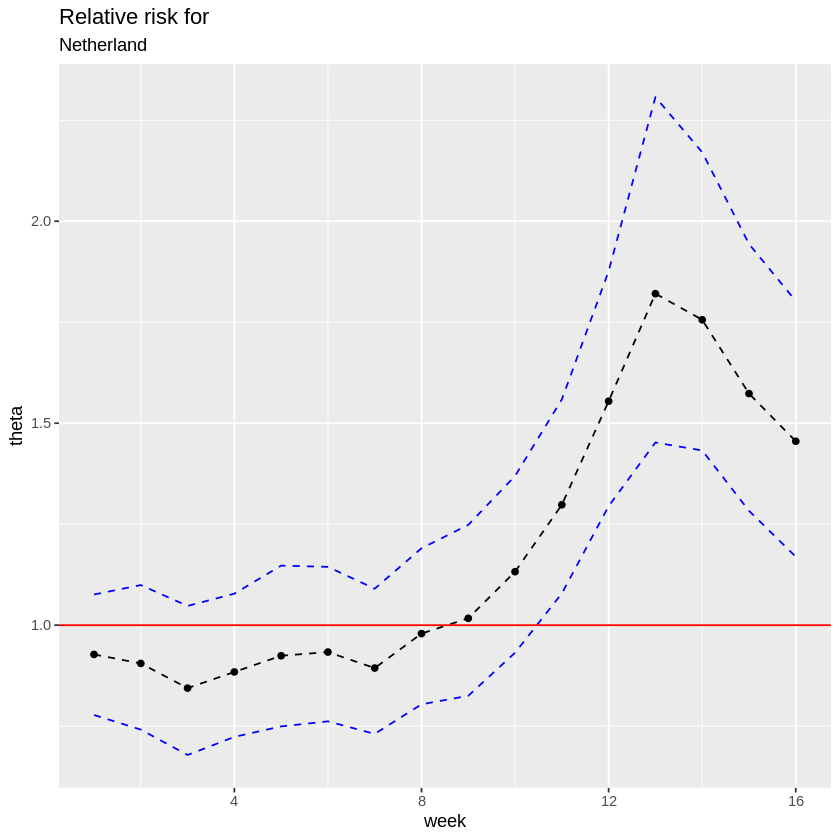

Saving 6.67 x 6.67 in image



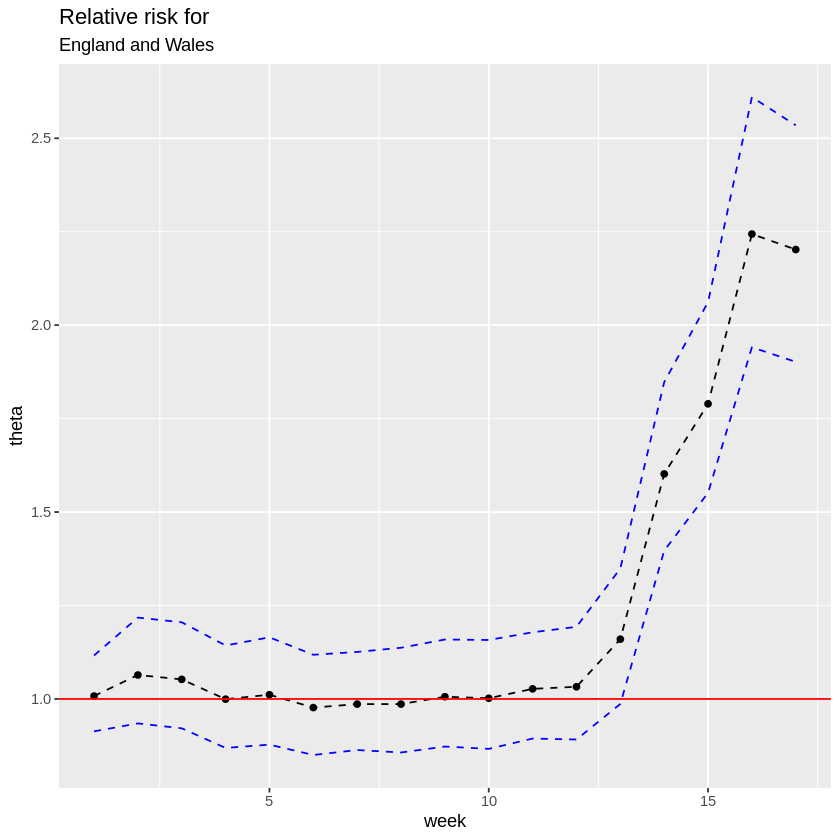

Saving 6.67 x 6.67 in image



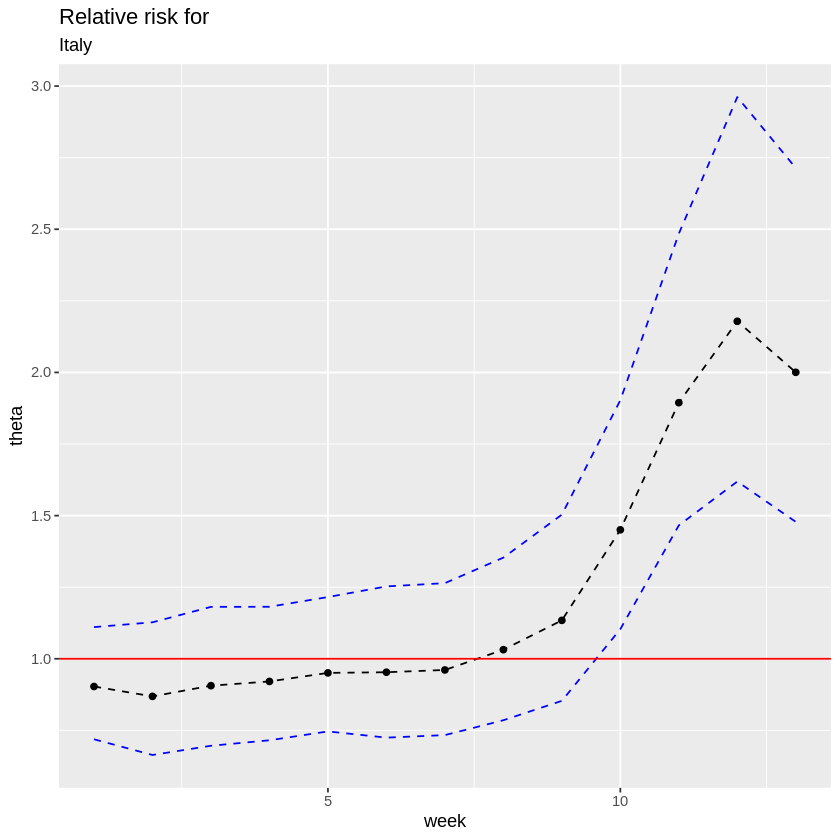

Saving 6.67 x 6.67 in image



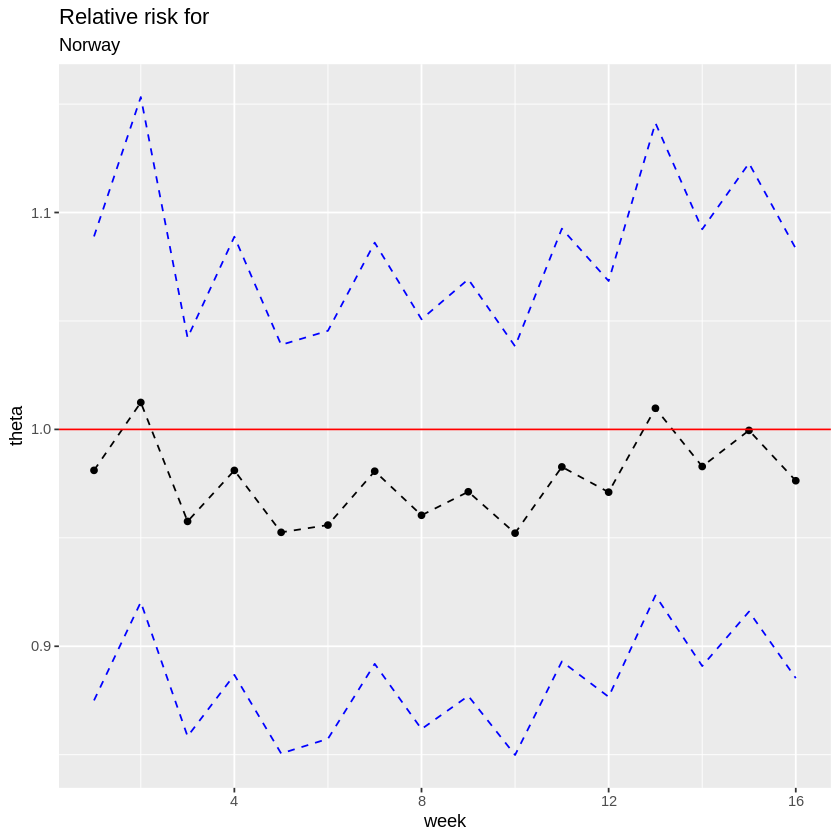

Saving 6.67 x 6.67 in image



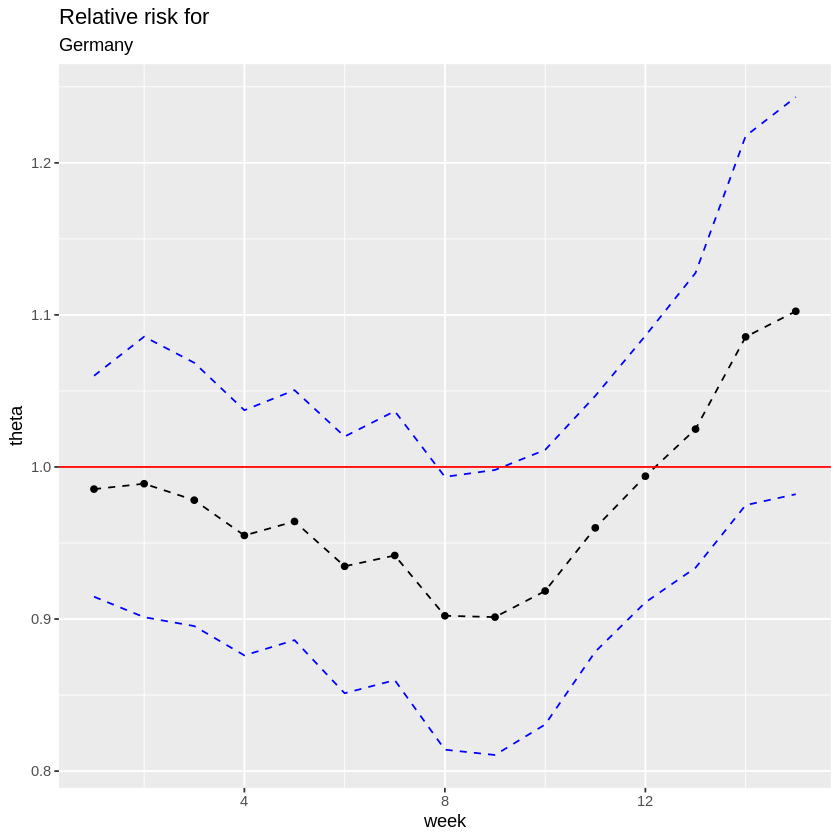

Saving 6.67 x 6.67 in image



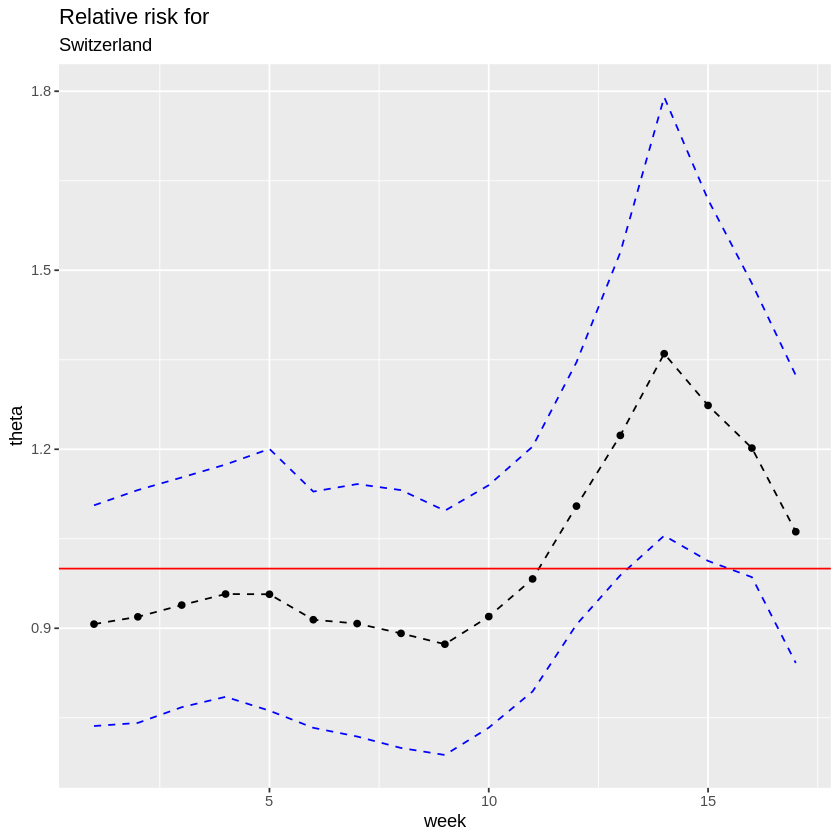

Saving 6.67 x 6.67 in image



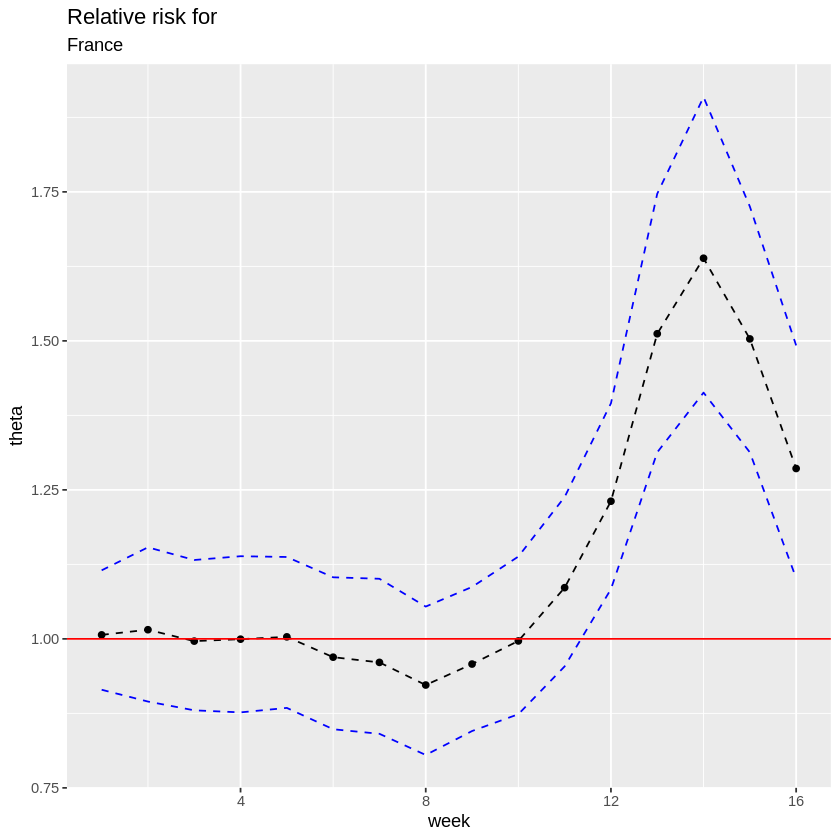

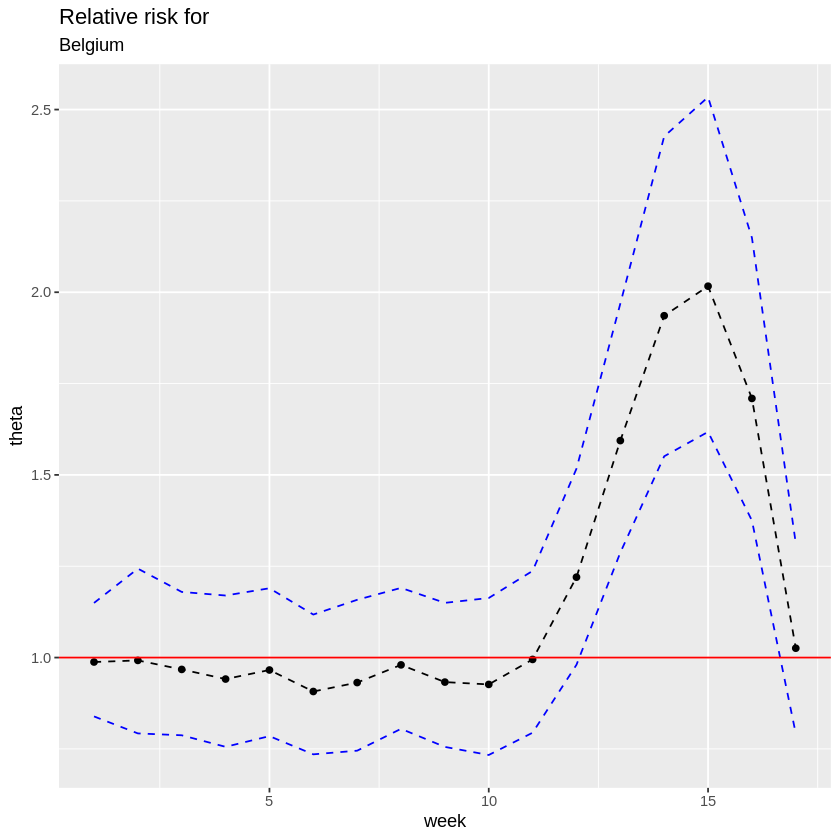

In [20]:
## Netherland

#print(risk_netherland)

#can this be used for validation?
#posterior <- as.data.frame(risk_netherland)
#mcmc_trace(risk_netherland, pars = "log_theta[12]")


data_netherland <- create_CI_theta_vec(risk_netherland, length(mean_netherland))
plot_risk(data_netherland, "Netherland")

## England and Wales
data_england_wales <- create_CI_theta_vec(risk_england_wales, length(mean_england))
plot_risk(data_england_wales, "England and Wales")

## Italy 
data_italy <- create_CI_theta_vec(risk_italy, length(mean_italy))
plot_risk(data_italy, "Italy")

## Norway
data_norway <- create_CI_theta_vec(risk_norway, length(mean_norway))
plot_risk(data_norway, "Norway")

## Germany
data_germany <- create_CI_theta_vec(risk_germany, length(mean_germany))
plot_risk(data_germany, "Germany")


#Switzerland
data_switzerland <- create_CI_theta_vec(risk_switzerland, length(mean_swiss))
plot_risk(data_switzerland, "Switzerland")

# France
data_france <- create_CI_theta_vec(risk_france, length(mean_france))
plot_risk(data_france, "France")


# Belgium
data_belgium <- create_CI_theta_vec(risk_belgium, length(mean_belgium))
plot_risk(data_belgium, "Belgium")

save.image("excess_deaths_output.Rdata")

# Future work

In the final report we will address the following  points:

* convergence issues,

* implementation and obtention of results for the excess deaths on top of reported deaths,

* exploring the possiblity of an additional layer in our hierarchical negative binomail model by gathering the different countries into the same model, 

* validation of the model.




<!-- add explanatory variables for the risk $\theta_i$ (% of elderly people, % smokers, % obecity, % time of lockdown).  -->

<!-- $log(\theta_i) \sim Normal(\beta_i + \beta_1 X_1 + \beta_2 X_2,\sigma_i^2)$ -->
